# Brace-Gatarek-Musiela (BGM) model

The BGM model is a term structure model widely used in interest rate derivatives pricing, particularly for instruments like caps, floors, and swaptions. Unlike short-rate models (e.g., Vasicek, CIR), which model the instantaneous short rate, the BGM model directly models forward LIBOR rates, making it more aligned with market observables. Here’s a detailed breakdown:

#### 1. **Model Setup**
- **Forward LIBOR Rates**: The BGM model focuses on forward LIBOR rates $ L(t, T_i, T_{i+1}) $, which are the rates set at time $ t $ for the period $[T_i, T_{i+1}]$, typically with a fixed tenor (e.g., 3 months or 6 months). These rates are related to zero-coupon bond prices via:
  $$
  1 + \delta_i L(t, T_i, T_{i+1}) = \frac{P(t, T_i)}{P(t, T_{i+1})}
  $$
  where:
  - $ \delta_i = T_{i+1} - T_i $ is the tenor (e.g., 0.5 years for semi-annual periods).
  - $ P(t, T_i) $ is the price at time $ t $ of a zero-coupon bond maturing at $ T_i $.

- **Tenor Structure**: Define a tenor structure $ 0 = T_0 < T_1 < \cdots < T_N $, where $ T_i $ are the reset dates, and $ \delta_i = T_{i+1} - T_i $.

#### 2. **Dynamics of Forward Rates**
- In the BGM model, each forward LIBOR rate $ L(t, T_i, T_{i+1}) $ follows a lognormal process under its associated forward measure $ Q^{T_{i+1}} $:
  $$
  dL(t, T_i, T_{i+1}) = L(t, T_i, T_{i+1}) \sigma_i(t) dW_i^{T_{i+1}}(t)
  $$
  where:
  - $ \sigma_i(t) $ is the volatility of the forward rate, which can be time-dependent (often assumed piecewise constant for simplicity).
  - $ W_i^{T_{i+1}}(t) $ is a Brownian motion under the $ T_{i+1} $-forward measure.

- **Volatility Structure**: The volatilities \( \sigma_i(t) \) are typically specified as deterministic functions. A common choice is:
  $$
  \sigma_i(t) = \sigma_i \quad \text{(constant volatility for each forward rate)}
  $$
  or a more flexible form like:
  $$
  \sigma_i(t) = \sigma_i e^{-\kappa_i (T_i - t)}
  $$
  to allow volatility to decay as the reset date approaches.

- **Correlation**: The Brownian motions \( W_i^{T_{i+1}} \) for different forward rates are correlated, with a correlation matrix $ \rho_{ij} $. A common parameterization is:
  $$
  \rho_{ij} = e^{-\beta |T_i - T_j|}
  $$
  where $ \beta > 0 $ controls the decay of correlation between forward rates.

#### 3. **Measure Changes**
- The BGM model uses different forward measures for each forward rate, which simplifies pricing of instruments like caps and floors. To simulate the entire term structure under a single measure (e.g., the spot measure or terminal measure), you need to adjust the drifts using the Girsanov theorem.
- Under the spot measure $ Q $, the dynamics of $ L(t, T_i, T_{i+1}) $ include a drift term:
  $$
  dL(t, T_i, T_{i+1}) = L(t, T_i, T_{i+1}) \left( \sum_{j=\eta(t)}^i \frac{\delta_j L(t, T_j, T_{j+1}) \sigma_j(t) \sigma_i(t) \rho_{ij}}{1 + \delta_j L(t, T_j, T_{j+1})} dt + \sigma_i(t) dW_i(t) \right)
  $$
  where $ \eta(t) $ is the index of the next reset date after $ t $.

#### 4. **Zero-Coupon Bond Pricing**
- To price a zero-coupon bond \( P(t, T) \), you need the forward rates up to $ T $. The bond price is:
  $$
  P(t, T) = \prod_{i: T_i < T \leq T_{i+1}} \frac{1}{1 + \delta_i L(t, T_i, T_{i+1})}
  $$
  - At $ t = 0 $, you can use the initial forward rates $ L(0, T_i, T_{i+1}) $, which are derived from the observed yield curve (e.g., your STRIPS data).
  - The yield for maturity $ T $ is then:
    $$
    y(0, T) = -\frac{\ln P(0, T)}{T} \times 100 \quad (\text{in percentage})
    $$

#### 5. **Calibration**
- The BGM model is calibrated by fitting the initial forward rates \( L(0, T_i, T_{i+1}) \) and volatilities \( \sigma_i \) to market data:
  - **Forward Rates**: Extract \( L(0, T_i, T_{i+1}) \) from the observed yield curve (e.g., STRIPS yields).
  - **Volatilities**: Calibrate \( \sigma_i \) to match market prices of interest rate derivatives (e.g., caplets, swaptions) or, in your case, to fit the yield curve directly.
- In your context, since you’re fitting to STRIPS yields, you’ll adjust the volatilities and possibly the initial forward rates to minimize the difference between model-implied yields and observed yields.

#### 6. **Advantages and Limitations**
- **Advantages**:
  - Directly models market-observable forward rates, making it intuitive for pricing LIBOR-based derivatives.
  - Lognormal dynamics ensure positive forward rates, unlike Vasicek.
  - Flexible volatility and correlation structures allow better fit to market data.
- **Limitations**:
  - Complex drift adjustments when simulating under a single measure.
  - Assumes lognormal forward rates, which may not capture all yield curve dynamics (e.g., stochastic volatility).
  - Calibration can be computationally intensive, especially with many forward rates.



In [113]:
import pandas as pd
import numpy as np

## Data Preparation

- Parsing: We parse the CSV data into a pandas DataFrame.
- Latest Data: We select the row for February 4, 2025.
- Extract Columns: For each maturity, we extract the time to maturity, price, and yield.
- Arrays: Convert the extracted data into numpy arrays for further processing.

Output:
- maturities: Times to maturity (e.g., 0.030116 for Feb 2025, 0.273785 for May 2025, ..., 14.524298 for Aug 2039).
- prices: Prices of the STRIPS (e.g., 99.932 for Feb 2025, ..., 51.226 for Aug 2039).
- yields: Yields in decimal form (e.g., 0.0252 for Feb 2025, ..., 0.04658 for Aug 2039).

In [114]:
#Data Preparation
df = pd.read_csv('/Users/dr/Documents/GitHub/FixedIncome/STRIPS_data.csv')

# Select the most recent date (2025-02-04)
latest_date = "2025-02-04"
latest_data = df[df['Date'] == latest_date].iloc[0]

# Extract times, prices, and yields
maturities = []
prices = []
yields = []

# There are 46 maturities, each with Price, Time, and Yield
for i in range(46):
    maturity_label = df.columns[1 + i*3].split('_')[1]  # e.g., 'Feb2025'
    time_col = f'Time_{maturity_label}'
    price_col = f'Price_{maturity_label}'
    yield_col = f'Yield_{maturity_label}'
    
    time = latest_data[time_col]
    price = latest_data[price_col]
    yield_val = latest_data[yield_col]
    
    maturities.append(time)
    prices.append(price)
    yields.append(yield_val)

# Convert to numpy arrays
maturities = np.array(maturities)
prices = np.array(prices)
yields = np.array(yields)
face_value = 100  # Assumed face value of STRIPS

print("Maturities:", maturities)
print("Prices:", prices)
print("Yields:", yields)

Maturities: [ 0.03011636  0.27378508  0.52566735  0.77754962  1.0294319   1.27310062
  1.52498289  1.77686516  2.02874743  2.27241615  2.52429843  2.7761807
  3.02806297  3.27446954  3.52635181  3.77823409  4.03011636  4.27378508
  4.52566735  5.27310062  5.52498289  5.77686516  6.02874743  6.27241615
  6.52429843  6.7761807   7.02806297  7.27446954  7.52635181  7.77823409
  8.03011636  8.27378508  8.52566735  8.77754962  9.0294319   9.27310062
  9.52498289  9.77686516 11.02806297 12.03011636 12.27378508 13.0294319
 13.27310062 14.02874743 14.27241615 14.52429843]
Prices: [99.932 98.863 97.544 96.805 95.935 94.82  94.007 93.401 92.335 90.939
 90.099 89.155 88.04  87.107 86.492 85.241 84.677 83.381 82.523 79.835
 78.817 78.023 77.122 76.167 75.256 74.384 73.557 72.766 71.9   71.245
 70.251 69.435 68.631 67.886 67.017 66.265 65.478 64.734 62.076 58.889
 58.016 55.667 55.083 52.863 51.926 51.226]
Yields: [0.0252  0.04204 0.03694 0.04243 0.04081 0.04221 0.04088 0.03887 0.03973
 0.04222 0.0

In [125]:
# Filter out very short maturities (<0.1 years) for calibration
min_maturity = 0.1
mask = maturities >= min_maturity
filtered_maturities = maturities[mask]
filtered_prices = prices[mask]
filtered_yields = yields[mask]

## Compute Initial Forward Rates

In [126]:
# Compute initial forward rates (for baseline, but we'll override with Nelson-Siegel)
deltas = np.diff(maturities)
initial_forwards = []
for i in range(len(maturities) - 1):
    P_i = prices[i]
    P_ip1 = prices[i + 1]
    delta_i = deltas[i]
    L = (P_i / P_ip1 - 1) / delta_i
    if delta_i < 0.1:
        L = min(L, 0.05)
    initial_forwards.append(max(L, 0.0001))

initial_forwards = np.array(initial_forwards)
print("Initial Forward Rates (Baseline):", initial_forwards)

Initial Forward Rates (Baseline): [0.04437559 0.05368422 0.03030743 0.03600349 0.04825865 0.03433466
 0.02575867 0.04583458 0.06299926 0.03701363 0.04203671 0.05028023
 0.04346866 0.0282294  0.05826546 0.02644332 0.06378787 0.04127762
 0.04504676 0.05127791 0.04040176 0.04638194 0.05145608 0.04805954
 0.04654139 0.04463586 0.04411596 0.047818   0.0364997  0.05617412
 0.04822941 0.04650912 0.04356909 0.05147984 0.04657296 0.04771794
 0.0456292  0.03422199 0.05400787 0.06175423 0.05584269 0.04351064
 0.05557536 0.07405509 0.05425128]


## BGM Model

In [127]:
# Model Class with Nelson-Siegel Forward Rates
class BGM:
    def __init__(self, times, ns_params, volatilities):
        self.times = np.array(times)
        self.ns_params = ns_params  # Nelson-Siegel parameters: [beta0, beta1, beta2, tau]
        self.volatilities = np.array(volatilities)
        self.deltas = np.diff(times)
        self.N = len(times) - 1
        self.forwards = self.compute_ns_forwards()
    
    def compute_ns_forwards(self):
        """Compute forward rates using Nelson-Siegel parameterization."""
        beta0, beta1, beta2, tau = self.ns_params
        forwards = []
        for i in range(self.N):
            t = self.times[i]
            # Nelson-Siegel forward rate: beta0 + beta1*exp(-t/tau) + beta2*(t/tau)*exp(-t/tau)
            f = beta0 + beta1 * np.exp(-t/tau) + beta2 * (t/tau) * np.exp(-t/tau)
            forwards.append(max(f, 0.0001))
        return np.array(forwards)
    
    def zero(self, t0, T):
        if T <= self.times[0]:
            return 1.0
        idx = np.searchsorted(self.times, T, side='left') - 1
        if idx < 0:
            idx = 0
        price = 1.0
        for i in range(idx + 1):
            if i < self.N:
                price /= (1 + self.deltas[i] * self.forwards[i])
        if idx + 1 < len(self.times) and self.times[idx + 1] > T:
            fraction = (self.times[idx + 1] - T) / self.deltas[idx]
            price *= (1 + self.deltas[idx] * self.forwards[idx]) ** fraction
        return max(price, 1e-10)
    
    def yield_curve(self, tau):
        if tau <= 0:
            return np.nan
        p = self.zero(0, tau)
        return -np.log(p) / tau * 100
    
    def update_params(self, ns_params):
        self.ns_params = ns_params
        self.forwards = self.compute_ns_forwards()

In [128]:
# Test the Model
# Initial Nelson-Siegel parameters: [beta0, beta1, beta2, tau]
# beta0: long-term rate, beta1: short-term adjustment, beta2: hump, tau: decay rate
initial_ns_params = [0.04, -0.02, 0.01, 1.0]  # Reasonable starting values
volatilities = np.full(len(initial_forwards), 0.2)
bgm = BGM(maturities, initial_ns_params, volatilities)

# Test bond prices and yields
test_prices = np.array([bgm.zero(0, tau) * face_value for tau in maturities])
test_yields = np.array([bgm.yield_curve(tau) for tau in maturities])
print("Initial Model Prices:", test_prices)
print("Initial Model Yields:", test_yields)

Initial Model Prices: [100.          99.49366067  98.82475209  98.05210476  97.21023173
  96.35250577  95.43984323  94.5122147   93.57828355  92.67415815
  91.74332947  90.81869604  89.90196177  89.01370345  88.11521432
  87.2265184   86.34769781  85.50676749  84.64716992  82.17360245
  81.35053312  80.53625669  79.73059759  78.95913583  78.16996277
  77.38895248  76.61597294  75.86737078  75.10992491  74.36016699
  73.6179956   72.90704028  72.17951963  71.45931333  70.74633722
  70.06330399  69.36431896  68.67233023  65.39889113  62.87849442
  62.27154028  60.4445297   59.8610753   58.10479854  57.54393094
  56.9699411 ]
Initial Model Yields: [-0.          1.85410238  2.24896703  2.52989221  2.74852717  2.91860549
  3.06062784  3.17644271  3.27156755  3.34800123  3.41383586  3.46897513
  3.51546266  3.55415909  3.587985    3.6170811   3.64227804  3.66360634
  3.68295983  3.72335155  3.73580884  3.74706183  3.75727739  3.76632751
  3.77488435  3.78275255  3.79001452  3.79661348  3.802

In [ ]:
import matplotlib.pyplot as plt

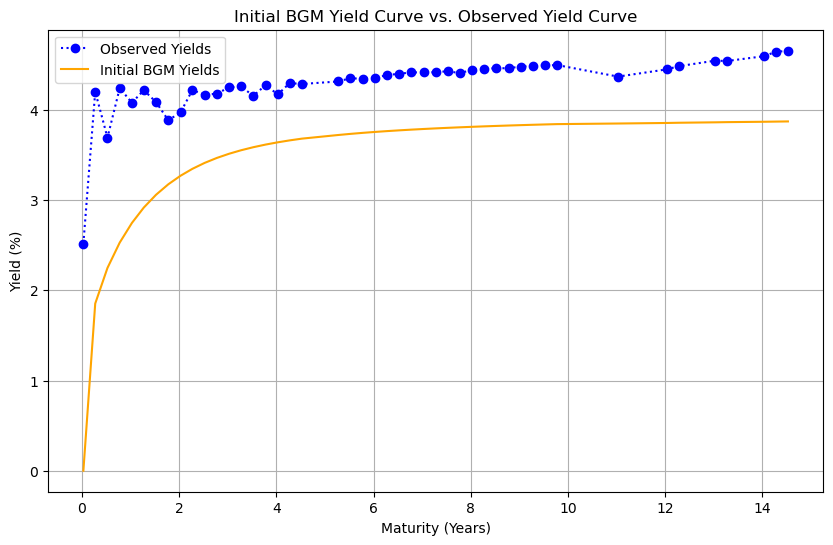

In [130]:
# Plot Initial Model Curve vs. Yield Curve
plt.figure(figsize=(10, 6))
plt.plot(maturities, yields * 100, marker='o', linestyle='dotted', label='Observed Yields', color='blue')
plt.plot(maturities, test_yields, linestyle='solid', label='Initial BGM Yields', color='orange')
plt.xlabel('Maturity (Years)')
plt.ylabel('Yield (%)')
plt.title('Initial BGM Yield Curve vs. Observed Yield Curve')
plt.legend()
plt.grid(True)
plt.show()

## Define the Fitter Class

In [ ]:
from scipy.optimize import minimize

In [131]:
# Model Fitter Class for Metrics
class ModelFitter:
    def __init__(self, model, maturities, observed_yields, all_maturities):
        self.model = model
        self.maturities = maturities
        self.observed_yields = observed_yields
        self.all_maturities = all_maturities
    
    def yield_error(self, params):
        self.model.update_params(params)
        model_yields = np.array([self.model.yield_curve(tau) for tau in self.maturities])
        # Add regularization to penalize large parameters
        reg_term = 0.01 * np.sum(params[:3]**2)  # Penalize beta0, beta1, beta2
        return np.sum((model_yields - self.observed_yields) ** 2) + reg_term
    
    def calibrate(self):
        bounds = [(0.0, 0.1), (-0.1, 0.1), (-0.1, 0.1), (0.1, 5.0)]  # Bounds for [beta0, beta1, beta2, tau]
        result = minimize(
            self.yield_error,
            self.model.ns_params,
            method='L-BFGS-B',
            bounds=bounds,
            options={'disp': True, 'maxiter': 1000}
        )
        if result.success:
            self.model.update_params(result.x)
            print("Calibration Successful. Optimized NS Parameters:", result.x)
        else:
            print("Calibration Failed:", result.message)
        return result.success
    
    def r_squared(self):
        model_yields = np.array([self.model.yield_curve(tau) for tau in self.maturities])
        mean_yield = np.mean(self.observed_yields)
        ss_tot = np.sum((self.observed_yields - mean_yield) ** 2)
        ss_res = np.sum((self.observed_yields - model_yields) ** 2)
        return 1 - ss_res / ss_tot if ss_tot > 0 else np.nan
    
    def rmse(self):
        model_yields = np.array([self.model.yield_curve(tau) for tau in self.maturities])
        return np.sqrt(np.mean((self.observed_yields - model_yields) ** 2))
    
    def aic(self):
        n = len(self.maturities)
        k = 4  # Number of Nelson-Siegel parameters
        model_yields = np.array([self.model.yield_curve(tau) for tau in self.maturities])
        rss = np.sum((self.observed_yields - model_yields) ** 2)
        if rss <= 0:
            rss = 1e-10  # Avoid log(0)
        return n * np.log(rss / n) + 2 * k

# Calibrate the model
fitter = ModelFitter(bgm, filtered_maturities, filtered_yields * 100, maturities)
fitter.calibrate()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.19511D+01    |proj g|=  9.00000D-01

At iterate    1    f=  2.89205D+00    |proj g|=  6.09814D-01

At iterate    2    f=  2.63790D+00    |proj g|=  1.99334D-01

At iterate    3    f=  2.59024D+00    |proj g|=  1.27823D-01

At iterate    4    f=  2.38326D+00    |proj g|=  1.16242D-01

At iterate    5    f=  2.16568D+00    |proj g|=  2.46539D-01

At iterate    6    f=  1.72188D+00    |proj g|=  3.55477D-01

At iterate    7    f=  1.03136D+00    |proj g|=  9.94340D-02

At iterate    8    f=  5.60625D-01    |proj g|=  4.19663D-01

At iterate    9    f=  4.10553D-01    |proj g|=  2.54375D-01

At iterate   10    f=  4.02659D-01    |proj g|=  9.82539D-02

At iterate   11    f=  4.01239D-01    |proj g|=  9.82268D-02

At iterate   12    f=  4.01229D-01    |proj g|=  9.66174D-02

At iterate   13    f=  4.0

True

In [132]:
# Compute and print metrics
r2 = fitter.r_squared()
rmse = fitter.rmse()
aic = fitter.aic()
print(f"R-squared (filtered maturities): {r2:.3f}")
print(f"RMSE (filtered maturities): {rmse:.3f}")
print(f"AIC (filtered maturities): {aic:.1f}")

# Save metrics
metrics = {'R-squared': r2, 'RMSE': rmse, 'AIC': aic}
pd.DataFrame([metrics]).to_csv('bgm_metrics.csv', index=False)

R-squared (filtered maturities): 0.756
RMSE (filtered maturities): 0.094
AIC (filtered maturities): -204.4


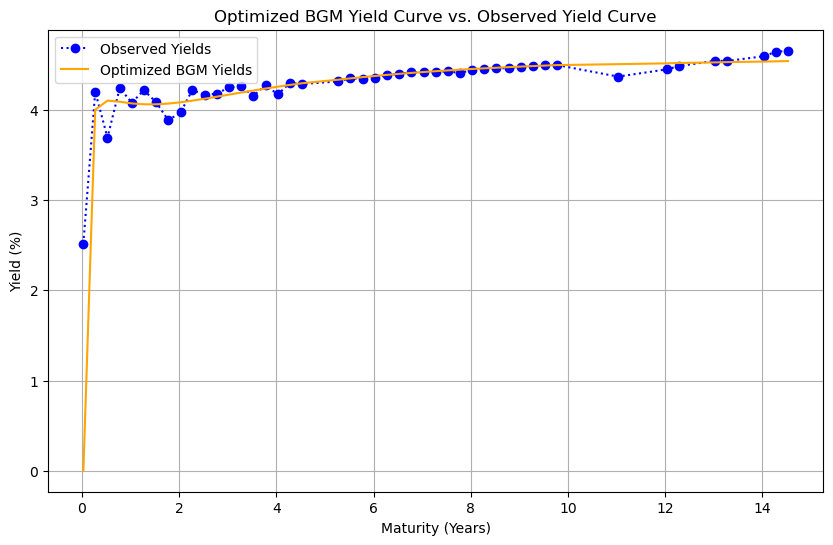

In [134]:
# Plot Optimized Model Curve vs. Yield Curve
optimized_yields = np.array([bgm.yield_curve(tau) for tau in maturities])
plt.figure(figsize=(10, 6))
plt.plot(maturities, yields * 100, marker='o', linestyle='dotted', label='Observed Yields', color='blue')
plt.plot(maturities, optimized_yields, linestyle='solid', label='Optimized BGM Yields', color='orange')
plt.xlabel('Maturity (Years)')
plt.ylabel('Yield (%)')
plt.title('Optimized BGM Yield Curve vs. Observed Yield Curve')
plt.legend()
plt.grid(True)
plt.show()

## Bond Pricing

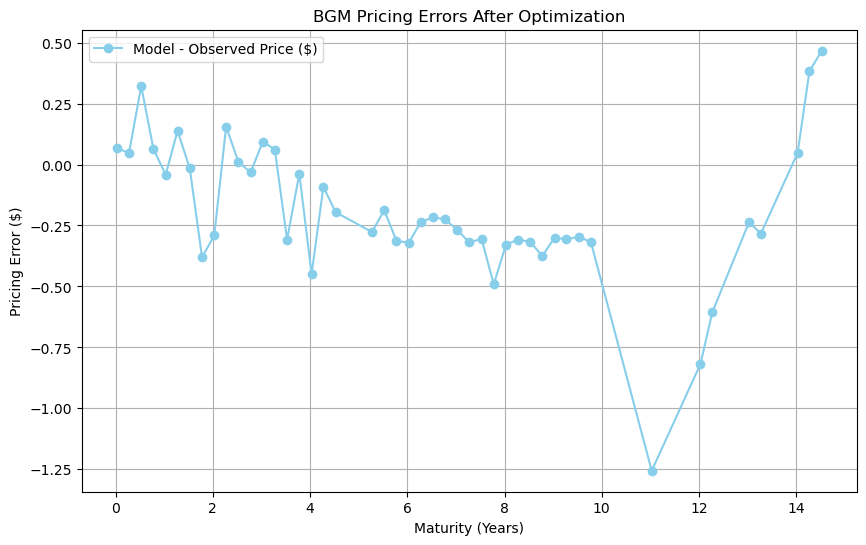

In [135]:
# Plot Pricing Errors
optimized_prices = np.array([bgm.zero(0, tau) * face_value for tau in maturities])
price_differences = optimized_prices - prices
plt.figure(figsize=(10, 6))
plt.plot(maturities, price_differences, 'o-', color='skyblue', label='Model - Observed Price ($)')
plt.xlabel('Maturity (Years)')
plt.ylabel('Pricing Error ($)')
plt.title('BGM Pricing Errors After Optimization')
plt.legend()
plt.grid(True)
plt.show()